In [30]:
import re
import string
from collections import defaultdict
import pickle
from tqdm import tqdm
from unidecode import unidecode
import matplotlib.pyplot as plt
from collections import Counter
import json
import dill
import random
from utils import beam_search

In [2]:

"""
Splits a paragraph into individual sentences based on punctuation marks.
:param paragraph: str, the input paragraph
:return: list, the sentences
"""
def split_into_sentences(paragraph):
    sentences = re.split(r'(?<!\w\.\w\.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', paragraph)
    return [sentence.strip() for sentence in sentences if sentence.strip()]


In [3]:
paragraph = "Python is amazing. It is versatile! Do you like Python?"
result = split_into_sentences(paragraph)
print(result)

['Python is amazing.', 'It is versatile!', 'Do you like Python?']


In [5]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
  return "".join([char for char in text if char not in string.punctuation])

In [6]:
sentence = "Kiểm tra thử loại bỏ các dấu câu!!! Ngày mai, trời lại sáng"
remove_punctuation(sentence)

'Kiểm tra thử loại bỏ các dấu câu Ngày mai trời lại sáng'

In [7]:
def remove_punctuation_corpus(corpus):
  corpus_process = []
  for sentence in tqdm(corpus):
    corpus_process.append(remove_punctuation(sentence))
  return corpus_process

In [11]:
def remove_diacritic(text):
    """Hàm loại bỏ dấu tiếng Việt"""
    DIACRITIC_MAP = {
        "áàảãạăắằẳẵặâấầẩẫậ": "a",
        "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬ": "A",
        "éèẻẽẹêếềểễệ": "e",
        "ÉÈẺẼẸÊẾỀỂỄỆ": "E",
        "íìỉĩị": "i",
        "ÍÌỈĨỊ": "I",
        "óòỏõọôốồổỗộơớờởỡợ": "o",
        "ÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢ": "O",
        "úùủũụưứừửữự": "u",
        "ÚÙỦŨỤƯỨỪỬỮỰ": "U",
        "ýỳỷỹỵ": "y",
        "ÝỲỶỸỴ": "Y",
        "đ": "d",
        "Đ": "D",
    }
    for accents, char in DIACRITIC_MAP.items():
        text = re.sub(f"[{accents}]", char, text)
    return text

In [12]:
file_path = 'train_ipt_500k.pkl'
with open(file_path, 'rb') as f:
    train_ipt_500k = pickle.load(f)

In [13]:
dataset = train_ipt_500k[:5678]
sentences_data = [sent for sentence in dataset for sent in split_into_sentences(sentence)]
#remove_punctuation_corpus(dataset)
print(sentences_data[:10])


['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.', 'Mọi chi tiết có thể tìm thấy tại website của ISOC.', 'Internet Society nằm ở gần thủ đô Washington, DC, Hoa Kỳ và Geneva, Thụy Sĩ.', 'Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65.000 cá nhân.', 'Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích.', 'Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới.']


In [14]:
sentences_data_length = [len(sentence) for sentence in sentences_data]
lengths_counts = Counter(sentences_data_length)

In [15]:
print(f"Tổng số lượng câu là: {len(sentences_data)}")
print(f"Độ dài trung bình của các câu: {sum(sentences_data_length) / len(sentences_data)}")
print(f"Độ dài câu dài nhất: {max(sentences_data_length)}")
print(f"Độ dài câu ngắn nhất: {min(sentences_data_length)}")
most_common_length, frequency_max = lengths_counts.most_common(1)[0]
print(f"Độ dài câu xuất hiện nhiều nhất: {frequency_max}")
least_common_length, frequency_min = lengths_counts.most_common()[-1]
print(f"Độ dài câu xuất hiện ít nhất: {frequency_min}")

Tổng số lượng câu là: 17850
Độ dài trung bình của các câu: 138.46935574229693
Độ dài câu dài nhất: 896
Độ dài câu ngắn nhất: 1
Độ dài câu xuất hiện nhiều nhất: 128
Độ dài câu xuất hiện ít nhất: 1


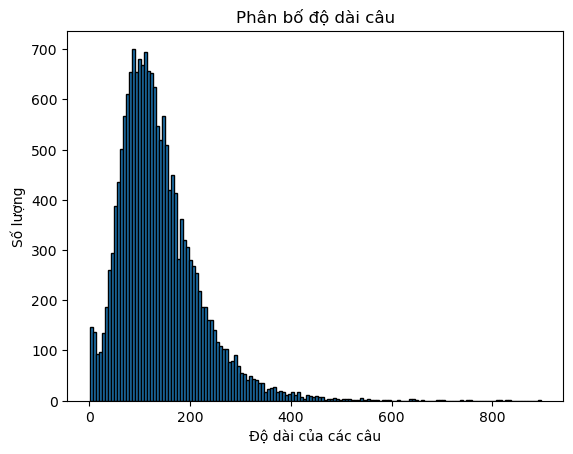

In [81]:
plt.hist(sentences_data_length, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.show()

In [17]:
sentences_data_new = [sentences_data[i] for i in range(len(sentences_data)) if len(sentences_data[i]) < 400]
print(f"Số phần tử của tập dữ liệu: {len(sentences_data_new)}")
sentences_data_length_new = [len(sentence) for sentence in sentences_data_new]

Số phần tử của tập dữ liệu: 17662


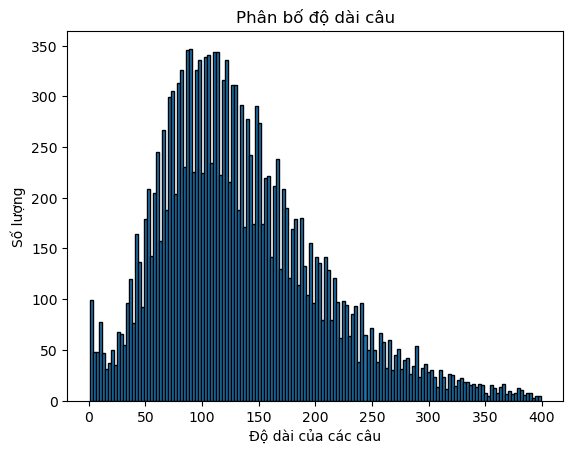

In [18]:
plt.hist(sentences_data_length_new, bins = 150, edgecolor = "black")
plt.title("Phân bố độ dài câu")
plt.xlabel("Độ dài của các câu")
plt.ylabel("Số lượng")
plt.show()

In [48]:
corpus_process = remove_punctuation_corpus(train_dataset_new)
print(corpus_process[:10])

100%|██████████| 5026/5026 [00:00<00:00, 57850.09it/s]

['Trang Chính\n', 'Internet Society\n', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành Tổ chức này chú trọng đến tiêu chuẩn giáo dục và các vấn đề về chính sách Với trên 145 tổ chức thành viên và 65000 thành viên cá nhân ISOC bao gồm những con người cụ thể trong cộng đồng Internet Mọi chi tiết có thể tìm thấy tại website của ISOC\n', 'Internet Society nằm ở gần thủ đô Washington DC Hoa Kỳ và Geneva Thụy Sĩ Số hội viên của nó bao gồm hơn 145 tổ chức thành viên và hơn 65000 cá nhân Thành viên còn có thể tự lập một chi nhánh của tổ chức tùy theo vị trí hoặc sở thích Hiện nay tổ chức có tới 90 chi nhánh trên toàn thế giới\n', 'Bảo đảm cổ vũ cho sự phát triển mở rộng và sử dụng Internet được thuận lợi nhất cho mọi người trên toàn thế giới\n', 'Tiếng Việt\n', 'Tiếng Việt cũng đã được công nhận là một ngôn ngữ dân tộc thiểu số tại Cộng hòa Séc\n', 'Tổ chức tiêu chuẩn hóa quốc tế đặt mã ngôn ngữ hai chữ

###    **start_prob:** Xác suất để 1 từ là bắt đầu của một câu

    P(s) = (số lần câu bắt đầu bởi từ s) / (tổng số câu)
###   **trans_prob:** Xác suất để một từ xuất hiện sau một từ
    
    P(xt = s' | xt-1 = s) = (Số lần xuất hiện của cặp từ ss') / (Số lần xuất hiện của từ s)

### **emit_prob:** Xác suất phát sinh, xác suất để 1 từ có có dấu tương ứng với từ có dấu

    P(x = o | y = s) = (số lần từ không dấu s tương ứng từ có dấu o) / (Số lượng từ không dấu s)

In [19]:
def compute_probabilities(dataset):
  start_count = defaultdict(int)
  trans_count = defaultdict(lambda: defaultdict(int))
  emit_count = defaultdict(lambda: defaultdict(int))
  for sentence in tqdm(dataset):
    words = sentence.split()
    prev_word = None
    for idx, word in enumerate(words):
      no_diacritic = remove_diacritic(word)
      emit_count[no_diacritic][word] += 1
      if idx == 0:
        start_count[word] += 1
      else:
        trans_count[prev_word][word] += 1
      prev_word = word
    start_prob = {k : v / sum(start_count.values()) for k, v in start_count.items()}
    trans_prob = {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in trans_count.items()}
    emit_prob =  {k : {k2 : v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in emit_count.items()}
  return start_count, trans_count , emit_count

In [21]:
states = defaultdict(list)

In [33]:
start_prob, trans_prob, emit_prob = compute_probabilities(sentences_data)

for word in emit_prob:
    states[remove_diacritic(word)].extend(emit_prob[word].keys())

100%|██████████| 17850/17850 [42:34<00:00,  6.99it/s]


In [44]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận,


In [27]:
path = r'D:\Tài liệu học đại học\Project1\Project-1\probabilities.dill' 

with open(path, 'rb') as f:
    states, start_prob, trans_prob, emit_prob = dill.load(f)

In [28]:
obs = "la mot to chuc hoat dong phi loi nhuan,"
result = beam_search(obs.split(" "), states, start_prob, trans_prob, emit_prob)
print("Chuỗi có dấu:", " ".join(result))

Chuỗi có dấu: là một tổ chức hoạt động phi lợi nhuận,


In [29]:
print(sentences_data[:5])

['Trang Chính', 'Internet Society', 'Internet Society hay ISOC là một tổ chức quốc tế hoạt động phi lợi nhuận, phi chính phủ và bao gồm các thành viên có trình độ chuyên ngành.', 'Tổ chức này chú trọng đến: tiêu chuẩn, giáo dục và các vấn đề về chính sách.', 'Với trên 145 tổ chức thành viên và 65.000 thành viên cá nhân, ISOC bao gồm những con người cụ thể trong cộng đồng Internet.']


In [34]:
random.seed(42)
test_data_1_result = random.sample(sentences_data, 1000)

In [35]:
test_data_1_result[:5]

['Rồi lại phải qua dãy núi lèn (đá không phá đất), đá đứng như tường, ở giữa có đường đi rất hiểm: đó là ải Giáp Khẩu, tức là ải Chi Lăng, ở phía bắc huyện Hữu Lũng thuộc Lạng Sơn ngày nay.',
 'Thành phố Hồ Chí Minh còn là một trung tâm mua sắm và giải trí.',
 'Trong 11 tháng đầu năm 2012, thành phố Huế đã nhận được 2,4 triệu lượt khách du lịch, tăng 24,6% so với cùng kỳ năm 2011.',
 'Bảng xếp hạng 100 phim Anh Quốc của BFI có "Monty Python\'s Life of Brian" (1979), phim này thường được công chúng Anh Quốc bình chọn là hài hước nhất mọi thời đại.',
 'Xấp xỉ 92% dân số toàn tỉnh cư trú trên đảo Newfoundland (cùng các đảo nhỏ xung quanh), trong đó hơn một nửa cư trú tại bán đảo Avalon.']

In [41]:
test_data_1 = [remove_diacritic(test_data_no_diacritic) for test_data_no_diacritic in test_data_1_result]
test_data_1[:5]

['Roi lai phai qua day nui len (da khong pha dat), da dung nhu tuong, o giua co duong di rat hiem: do la ai Giap Khau, tuc la ai Chi Lang, o phia bac huyen Huu Lung thuoc Lang Son ngay nay.',
 'Thanh pho Ho Chi Minh con la mot trung tam mua sam va giai tri.',
 'Trong 11 thang dau nam 2012, thanh pho Hue da nhan duoc 2,4 trieu luot khach du lich, tang 24,6% so voi cung ky nam 2011.',
 'Bang xep hang 100 phim Anh Quoc cua BFI co "Monty Python\'s Life of Brian" (1979), phim nay thuong duoc cong chung Anh Quoc binh chon la hai huoc nhat moi thoi dai.',
 'Xap xi 92% dan so toan tinh cu tru tren dao Newfoundland (cung cac dao nho xung quanh), trong do hon mot nua cu tru tai ban dao Avalon.']

In [71]:
def compare_words(sentence1, sentence2):
    words1 = sentence1.split()
    words2 = sentence2.split()
    same = 0
    for i in range(len(words1)):
        if words1[i] == words2[i]:
            same += 1
    similarity_prob = (same / len(words1)) * 100
    return similarity_prob

In [44]:
for test_data in test_data_1[:5]:
    test_data_diacritic = " ".join(beam_search(test_data.split(" "), states, start_prob, trans_prob, emit_prob))
    print(test_data_diacritic)

Rồi lại phải qua dãy núi lèn (đá không phá đất), đá đứng như tường, ở giữa có đường đi rất hiểm: do là ải Giáp Khẩu, tức là ải Chi Lăng, ở phía bắc huyền Hữu Lũng thuộc Làng Sơn ngày này.
Thành phố Hồ Chí Minh con là một trung tâm mua sấm va giai tri.
Trong 11 tháng đầu năm 2012, thành phố Huệ đã nhận được 2,4 triệu lượt khách du lịch, tăng 24,6% so với cùng kỳ năm 2011.
Bằng xếp hạng 100 phim Anh Quốc của BFI có "Monty Python's Life of Brian" (1979), phim nay thường được công chúng Anh Quốc bình chọn là hài hước nhất mọi thời đãi.
Xấp xỉ 92% dân số toàn tỉnh cư trữ trên dao Newfoundland (cùng các đạo nho xung quanh), trong đó hơn một nửa cư trú tại bán đảo Avalon.


In [77]:
similarity_prob = 0
similarity_prob_list = []
for i in range(len(test_data_1)):
    test_data_diacritic = " ".join(beam_search(test_data_1[i].split(" "), states, start_prob, trans_prob, emit_prob))
    similarity_prob += compare_words(test_data_diacritic, test_data_1_result[i]) / len(test_data_1)
    similarity_prob_list.append(compare_words(test_data_diacritic, test_data_1_result[i]))


In [74]:
print(f"{similarity_prob:.2f}")

89.65


In [82]:
similarity_prob_list[:5]

[90.69767441860465,
 66.66666666666666,
 96.15384615384616,
 90.9090909090909,
 86.20689655172413]

In [84]:
prob_counts = Counter(similarity_prob_list)

In [86]:
print(f"Xác suất cao nhất: {max(similarity_prob_list)}")
print(f"Xác suất thấp nhất: {min(similarity_prob_list)}")
most_common_prob, frequency_prob_max = prob_counts.most_common(1)[0]
print(f"Xác suất xuất hiện nhiều nhất: {frequency_prob_max}")
least_common_prob, frequency_prob_min = prob_counts.most_common()[-1]
print(f"Xác suất xuất hiện ít nhất: {frequency_prob_min}")

Xác suất cao nhất: 100.0
Xác suất thấp nhất: 0.0
Xác suất xuất hiện nhiều nhất: 183
Xác suất xuất hiện ít nhất: 1


In [88]:
for i in range(len(similarity_prob_list)):
    if similarity_prob_list[i] == 0:
        print(test_data_1_result[i])
        print(test_data_1[i])

Thứ trưởng
Thu truong


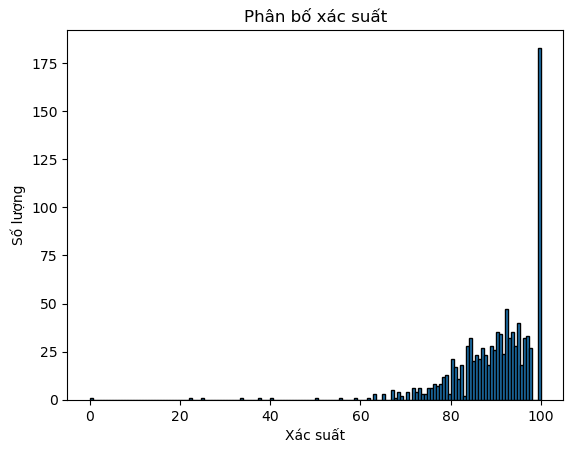

In [83]:
plt.hist(similarity_prob_list, bins = 150, edgecolor = "black")
plt.title("Phân bố xác suất")
plt.xlabel("Xác suất")
plt.ylabel("Số lượng")
plt.show()

In [89]:
dataset_test = train_ipt_500k[5678:6789]
sentences_data_test = [sent for sentence in dataset_test for sent in split_into_sentences(sentence)]

In [90]:
sentences_data_test[:5]

['XHTML đòi hỏi phải viết lại phần trên thành:',
 'Phong trào Chữ thập đỏ và Trăng lưỡi liềm đỏ quốc tế',
 'Ngày 22 tháng 08, 1864, 12 nước kết thúc hội nghị ở Genève và thành lập hội Chữ thập đỏ quốc tế với Hiệp định Genève thứ nhất.',
 'Tổ chức này có hơn 97 triệu tình nguyện viên.',
 'Các nguyên tắc gốc của phong trào là nhân đạo, vô tư, trung lập, độc lập, tự nguyện, thống nhất, và toàn cầu.']

In [93]:
len(sentences_data_test)

3296

In [97]:
test_data_2_result = [sentence for sentence in sentences_data_test if len(sentence) < 400]

In [98]:
test_data_2_result[:5]

['XHTML đòi hỏi phải viết lại phần trên thành:',
 'Phong trào Chữ thập đỏ và Trăng lưỡi liềm đỏ quốc tế',
 'Ngày 22 tháng 08, 1864, 12 nước kết thúc hội nghị ở Genève và thành lập hội Chữ thập đỏ quốc tế với Hiệp định Genève thứ nhất.',
 'Tổ chức này có hơn 97 triệu tình nguyện viên.',
 'Các nguyên tắc gốc của phong trào là nhân đạo, vô tư, trung lập, độc lập, tự nguyện, thống nhất, và toàn cầu.']

In [99]:
len(test_data_2_result)

3246

In [95]:
test_data_2 = [remove_diacritic(test_data_no_diacritic) for test_data_no_diacritic in sentences_data_test_length_new]


In [96]:
test_data_2[:5]

['XHTML doi hoi phai viet lai phan tren thanh:',
 'Phong trao Chu thap do va Trang luoi liem do quoc te',
 'Ngay 22 thang 08, 1864, 12 nuoc ket thuc hoi nghi o Geneve va thanh lap hoi Chu thap do quoc te voi Hiep dinh Geneve thu nhat.',
 'To chuc nay co hon 97 trieu tinh nguyen vien.',
 'Cac nguyen tac goc cua phong trao la nhan dao, vo tu, trung lap, doc lap, tu nguyen, thong nhat, va toan cau.']

In [100]:
similarity_prob_test = 0
similarity_prob_list_test = []
for i in range(len(test_data_2)):
    test_data_diacritic = " ".join(beam_search(test_data_2[i].split(" "), states, start_prob, trans_prob, emit_prob))
    similarity_prob += compare_words(test_data_diacritic, test_data_2[i]) / len(test_data_2)
    similarity_prob_list.append(compare_words(test_data_diacritic, test_data_2_result[i]))


In [101]:
print(f"{similarity_prob_test:.2f}")

0.00
